<a href="https://colab.research.google.com/github/pachterlab/GYP_2022/blob/dev/delay_cat_sim_twospec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy


In [2]:
tau=1 #residence time
cat_rate = 3
gamma = 1.4
T = 2
nT = 100
t = np.linspace(0,T,nT)

In [3]:
nC = 5000
X = np.zeros((nT,nC,2))
for c_ in range(nC):
    arrival_time_queue_1 = [0]
    arrival_time_storage_1 = [0]
    arrival_time_queue_2 = []
    arrival_time_storage_2 = []

    while arrival_time_queue_1:
        arrival_of_x1 = arrival_time_queue_1.pop()
        dt = tau
        generated_molecule_num = np.random.poisson(dt*cat_rate)
        arrival_times_x2 = np.random.uniform(0,dt,generated_molecule_num) + arrival_of_x1
        arrival_time_queue_2 += list(arrival_times_x2)
        arrival_time_storage_2 += list(arrival_times_x2)
    arrival_time_storage_1 = np.asarray(arrival_time_storage_1)
    arrival_time_storage_2 = np.asarray(arrival_time_storage_2)
    exit_time_storage_1 = arrival_time_storage_1 + tau
    deg_times = np.random.exponential(1/gamma,arrival_time_storage_2.shape)
    exit_time_storage_2 = arrival_time_storage_2 + deg_times
    for tind,t_ in enumerate(t):
        extant_at_t_1 = (((exit_time_storage_1)>t_)&(arrival_time_storage_1<=t_)).sum()
        extant_at_t_2 = (((exit_time_storage_2)>t_)&(arrival_time_storage_2<=t_)).sum()
        X[tind,c_,0] = extant_at_t_1
        X[tind,c_,1] = extant_at_t_2

In [4]:
def meanspec(t):
    y_ = np.zeros_like(t)
    f = t<tau
    y_[f] = 1
    y_[~f] = np.exp(-gamma*(t[~f]-tau))
    y_ -= np.exp(-gamma*t)
    y_ *= cat_rate/gamma
    return y_
    # for t_ in t:


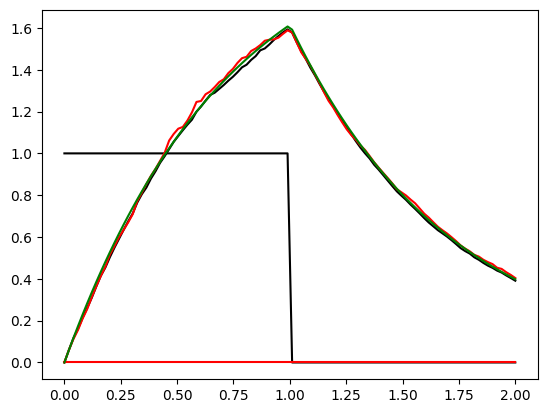

In [5]:
plt.plot(t,X.mean(1),color='k')
plt.plot(t,X.var(1),color='r')
y = meanspec(t)
plt.plot(t,y,color='g')

0.4040404040404041


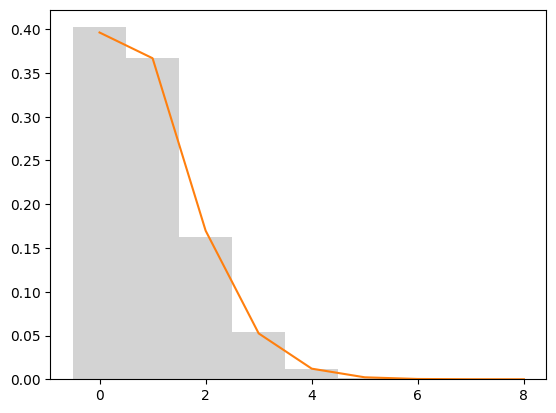

In [6]:
tind = 20
print(t[tind])
bins = np.arange(X[tind,:,1].max()+2)-0.5
plt.hist(X[tind,:,1],bins,facecolor='lightgray',density=True)
x = np.arange(X[tind,:,1].max()+2)
P = scipy.stats.poisson.pmf(x,y[tind])
plt.plot(x,P)

In [7]:
k = 1.2
tau=1 #residence time
cat_rate = 3
gamma = 1.4
# t2 = 1
T = 2
nT = 100
t = np.linspace(0,T,nT)

In [8]:
nC = 10000
X = np.zeros((nT,nC,2))
for c_ in range(nC):
    generated_x1_num = np.random.poisson(T*k)
    arrival_times_x1 =  np.random.uniform(0,T,generated_x1_num)
    arrival_time_queue_1 = list(arrival_times_x1)
    arrival_time_storage_1 = arrival_time_queue_1.copy()
    arrival_time_queue_2 = []
    arrival_time_storage_2 = []

    while arrival_time_queue_1:
        arrival_of_x1 = arrival_time_queue_1.pop()
        dt = tau
        generated_molecule_num = np.random.poisson(dt*cat_rate)
        arrival_times_x2 = np.random.uniform(0,dt,generated_molecule_num) + arrival_of_x1
        arrival_time_queue_2 += list(arrival_times_x2)
        arrival_time_storage_2 += list(arrival_times_x2)
    arrival_time_storage_1 = np.asarray(arrival_time_storage_1)
    arrival_time_storage_2 = np.asarray(arrival_time_storage_2)
    exit_time_storage_1 = arrival_time_storage_1 + tau
    deg_times = np.random.exponential(1/gamma,arrival_time_storage_2.shape)
    exit_time_storage_2 = arrival_time_storage_2 + deg_times
    for tind,t_ in enumerate(t):
        extant_at_t_1 = (((exit_time_storage_1)>t_)&(arrival_time_storage_1<=t_)).sum()
        extant_at_t_2 = (((exit_time_storage_2)>t_)&(arrival_time_storage_2<=t_)).sum()
        X[tind,c_,0] = extant_at_t_1
        X[tind,c_,1] = extant_at_t_2

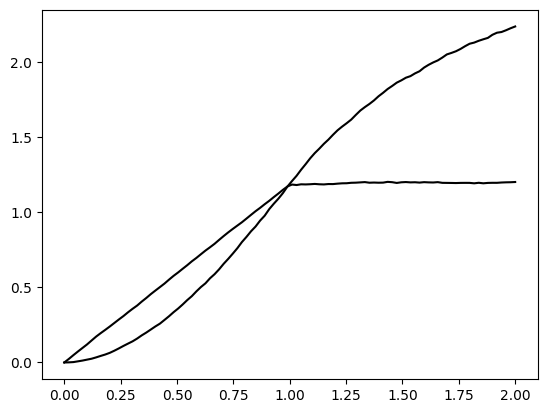

In [9]:
plt.plot(t,X.mean(1),color='k')


In [10]:

import scipy
from scipy import integrate

from scipy.fft import irfftn,ifftn
def eval_model_pss(p, limits, T):
    k, tau, q, gamma = p

    u = []
    mx = np.copy(limits)
    # mx[-1] = mx[-1] // 2 + 1
    for i in range(len(mx)):
        l = np.arange(mx[i])
        u_ = np.exp(-2j * np.pi * l / limits[i]) - 1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing="ij")
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    g = np.asarray(g,dtype=np.complex128)[:, :, None]
    gf = eval_model_pgf(p, g, T)
    gf = np.exp(gf)
    gf = gf.reshape(tuple(mx))
    Pss = ifftn(gf)

    Pss = Pss.squeeze()
    return Pss

def eval_model_pgf(p, g, T):
    k, tau, q, gamma = p
    gf = np.zeros_like(g[0])
    for ind in range(g.shape[1]):
        g_ = g[:,ind,0]
        fun = lambda s_: intfun(s_, g_, k, tau, q, gamma)
        gf[ind] = scipy.integrate.fixed_quad(fun, 0, T, n=60)[0]
    return gf

def intfun(s_, g_, k, tau, q, gamma):
    U = np.zeros_like(s_).astype(np.complex128)
    f = s_<tau
    U[f] = np.exp(g_[1]*q/gamma*(1-np.exp(-gamma*s_[f])))
    U[~f] = np.exp(g_[1]*q/gamma*(np.exp(-gamma*(s_[~f]-tau))-np.exp(-gamma*s_[~f])))
    U[f] *= (g_[0]+1)
    U-=1
    return U*k

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


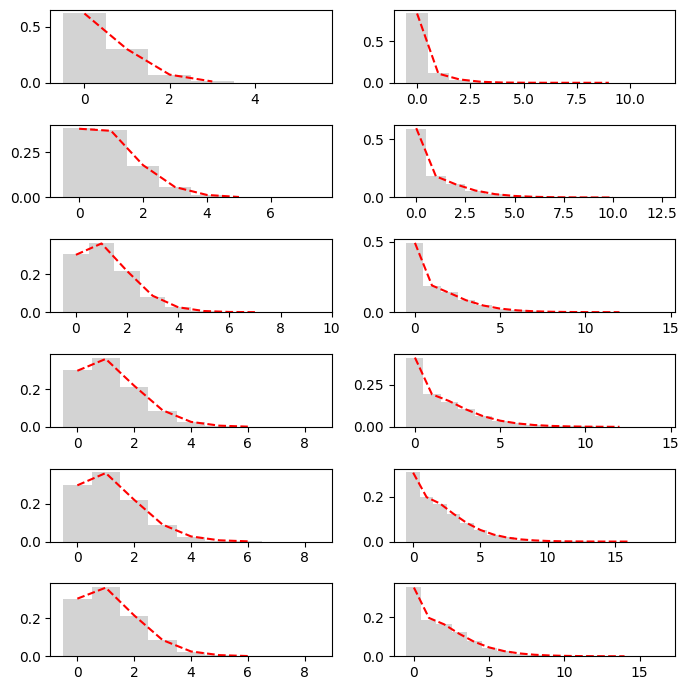

In [11]:
p = [k,tau,cat_rate,gamma]
t_pts = [20,40,50,60,80,70]
fig1,ax1 = plt.subplots(len(t_pts),2,figsize=(7,7))
for tind,t_pt in enumerate(t_pts):
    for species in range(2):
        bins = np.arange(X[t_pt,:,species].max()+3)-0.5
        ax1[tind,species].hist(X[t_pt,:,species],bins,color='lightgray',density=True)
        limits = np.asarray([1,1])
        limits[species] = X[t_pt,:,species].max()+30
        limits = limits.astype(int)
        P = eval_model_pss(p,limits,t[t_pt]).squeeze()
        # print(P.sum())
        P = P[:-30]
        # if species==1:
        #     print(P)
        ax1[tind,species].plot(P,'r--')
    limits = (X[t_pt,:,:].max(0)+30).astype(int)
    # P = eval_model_pss(p,limits,t[t_pt]).squeeze()
fig1.tight_layout()
plt.savefig('cat.png',dpi=450)

In [12]:
corrs = np.asarray([np.corrcoef(x_[:,0],x_[:,1])[0,1] for x_ in X])

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


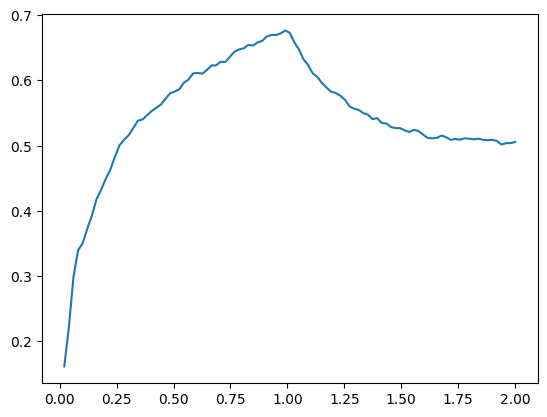

In [13]:
plt.plot(t,corrs)

In [ ]:
corrs_analytical = np.zeros(nT)
for t_pt in range(nT):
    limits = (X[t_pt,:,:].max(0)+50).astype(int)

    P = eval_model_pss(p,limits,t[t_pt]).squeeze()
    P = np.abs(P)/np.sum(np.abs(P))
    X_,Y_ = np.meshgrid(np.arange(P.shape[0]),np.arange(P.shape[1]),indexing='ij')
    mean_1 = (X_*P).sum()
    mean_2 = (Y_*P).sum()
    cov = (X_*Y_*P).sum()-mean_1*mean_2
    var_1 = ((X_**2)*P).sum()-mean_1**2
    var_2 = ((Y_**2)*P).sum()-mean_2**2
    corr_denom = np.sqrt(var_1)*np.sqrt(var_2)
    corrs_analytical[t_pt] = cov/corr_denom

<ipython-input-14-e8fb4c906af1>:14: RuntimeWarning: invalid value encountered in double_scalars
  corrs_analytical[t_pt] = cov/corr_denom


In [ ]:
plt.plot(t,corrs,'k',label='sim correlations')
plt.plot(t,corrs_analytical,label='computed directly from pmf')
plt.legend()
plt.xlabel('time')
plt.ylabel('pearson correlation')

In [ ]:
limits = (X[t_pt,:,:].max(0)+30).astype(int)
P = eval_model_pss(p,limits,t[t_pt]).squeeze()

In [ ]:
# P.sum()

In [ ]:
limits

In [ ]:
P = np.abs(P)/np.sum(np.abs(P))

In [ ]:
corrs[t_pt]

In [ ]:
X_,Y_ = np.meshgrid(np.arange(P.shape[0]),np.arange(P.shape[1]),indexing='ij')

In [ ]:
X_.shape

In [ ]:
X[t_pt].var(0)

In [ ]:
P.sum()

In [ ]:
mean_1 = (X_*P).sum()
mean_2 = (Y_*P).sum()
cov = (X_*Y_*P).sum()-mean_1*mean_2
var_1 = ((X_**2)*P).sum()-mean_1**2
var_2 = ((Y_**2)*P).sum()-mean_2**2
corr_denom = np.sqrt(var_1)*np.sqrt(var_2)

In [ ]:
corr_denom

In [ ]:
var_1,var_2

In [ ]:
cov/corr_denom

In [ ]:

plt.imshow(np.log(np.abs(P)),aspect='auto')